# A Beginner's Guide to Object Detection

Source: https://www.datacamp.com/community/tutorials/object-detection-guide and https://www.datacamp.com/community/tutorials/tensorflow-tutorial

Notable:
- Google's [SSD](https://arxiv.org/pdf/1512.02325.pdf) and Microsoft's Faster RCNN
- Trained data with enough data to learn general patterns - consider weather, lighting and camera conditions that vary in live streaming video. 
- Object localization - regions of interest (ROI)/region propsals
- Object classification - feature extraction, using transfer leanring recommended
- Non maximum suppression - overlapping boes are combined into a single bounding box
- evaluation metric: mAP (mean average precision) using 'intersection over union' (IoU)
- Fastai recommend calculating loss with: 
    1. Confidence: using categorical cross entropy accuracy and 
    2. Location: how far away the networks predictionsa are from training using L2 Norm. 
- Using TensorFlow Detection API. Protos are [here](https://github.com/tensorflow/models/tree/master/research/object_detection/protos)

In [1]:
# Systems libraries
import os

# Image libraries
import skimage
from skimage import transform 
from skimage.color import rgb2gray

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import random

# Deep Learning libraries
import tensorflow as tf

### 0. Getting familiar with TensorFlow

```
x1 = tf.constant([1,2,3,4])
x2 = tf.constant([5,6,7,8])
result = tf.multiply(x1, x2)
print(result) 
# no process has run to calculate the result = lazy evaluation

with tf.Session() as sess:
    output = sess.run(result)
    print(output)
```

### 1. Get the Belgium Traffic Sign Dataset
Data source: https://btsd.ethz.ch/shareddata/
Get the "BelgiumTS for Classification (cropped images), which are called "BelgiumTSC_Training" and "BelgiumTSC_Testing".

In [2]:
def load_data(data_directory):
    # there are 62 classes/directories
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        # get the path to every file in each of the 62 directories
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".ppm")]
        # read images and add a list of associated labels
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

In [3]:
ROOT_PATH = "/home/ubuntu/data/video/belgium-traffic-signs"
train_data_directory = os.path.join(ROOT_PATH, "Training")
test_data_directory = os.path.join(ROOT_PATH, "Testing")

In [4]:
images, labels = load_data(train_data_directory)

### 2. Statistics

In [5]:
images_np = np.asarray(images)

In [6]:
print('dimensions of images:', images_np.ndim)
print('number of images elements:', images_np.size)
images_np.shape

dimensions of images: 1
number of images elements: 4575


(4575,)

In [7]:
labels_np = np.asarray(labels)

In [8]:
print('dimensions of labels:', labels_np.ndim)
print('number of labels elements:', labels_np.size)
print('number of classes:', len(set(labels_np)))

dimensions of labels: 1
number of labels elements: 4575
number of classes: 62


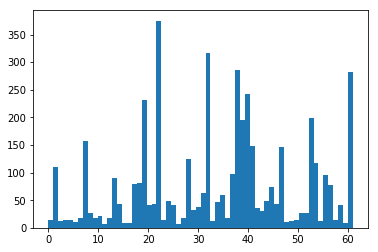

In [9]:
plt.hist(labels, 62)
plt.show()

Not all types of traffic signs are equally represented in the dataset. 

### 3. Visualising Traffic Signs

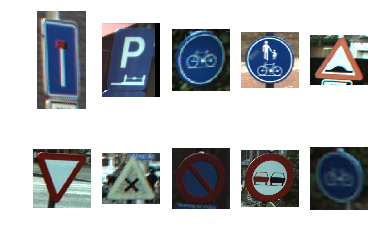

In [10]:
random.seed(20)
signs = []
for x in range(10):
    signs.append(random.randint(1, 4575))

for i in range(len(signs)):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(images[signs[i]])
    plt.subplots_adjust(wspace=0.2)
plt.show()    

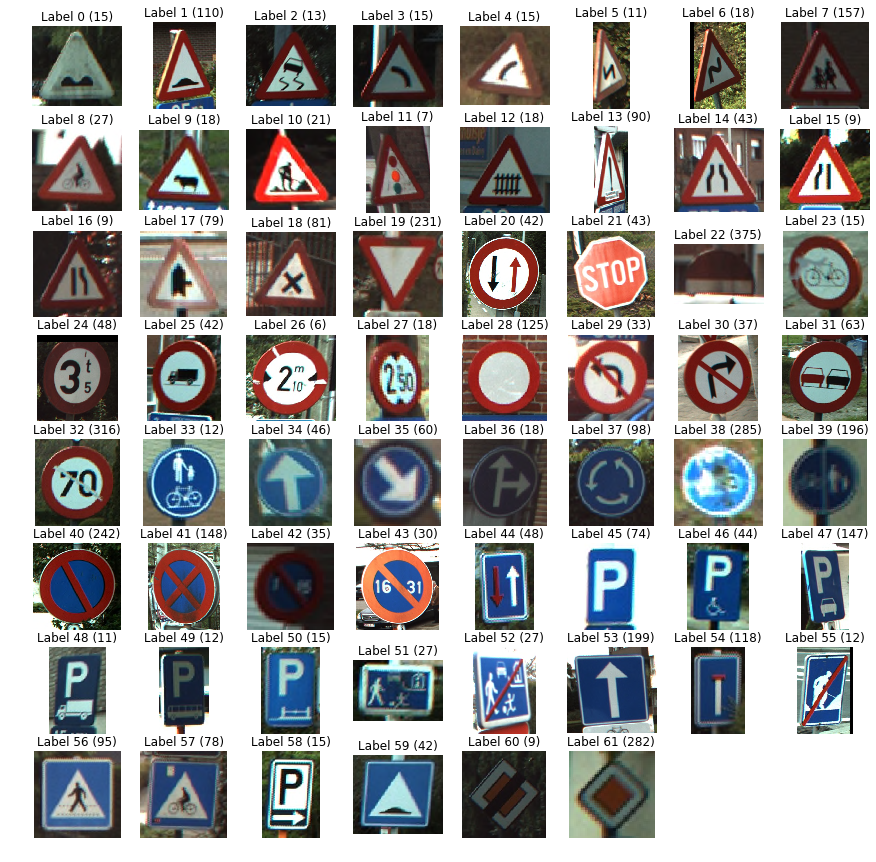

In [11]:
# Get the unique labels 
unique_labels = set(labels)

# Initialize the figure
plt.figure(figsize=(15, 15))

# Set a counter
i = 1

# For each unique label,
for label in unique_labels:
    # You pick the first image for each label
    image = images[labels.index(label)]
    # Define 64 subplots 
    plt.subplot(8, 8, i)
    # Don't include axes
    plt.axis('off')
    # Add a title to each subplot 
    plt.title("Label {0} ({1})".format(label, labels.count(label)))
    # Add 1 to the counter
    i += 1
    # And you plot this first image 
    plt.imshow(image)
    
# Show the plot
plt.show()

### 4. Feature Extraction

In [12]:
images28 = [transform.resize(image, (28,28)) for image in images]

/home/ubuntu/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


The image is squashed to the new dimensions

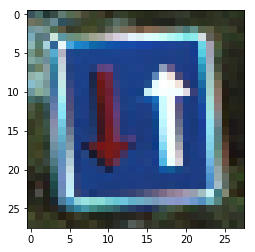

In [13]:
plt.imshow(images28[0])

In [14]:
images28_np = np.asarray(images28)

In [15]:
images28_np.shape

(4575, 28, 28, 3)

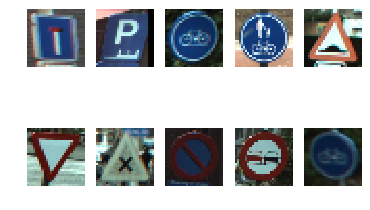

In [16]:
random.seed(20)
signs = []
for x in range(10):
    signs.append(random.randint(1, 4575))

for i in range(len(signs)):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(images28[signs[i]])
    plt.subplots_adjust(wspace=0.2)
plt.show()  

Skimage's transform.resize has noramlised the pixel values. Between 0 to 1

In [17]:
(images28_np.min(), images28_np.max())

(0.0, 1.0)

### 5. Image Conversion to Grayscale

In [18]:
images28_gray = rgb2gray(images28_np)

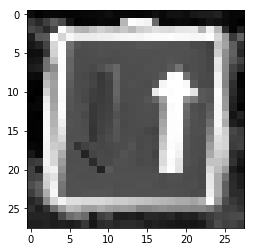

In [19]:
plt.imshow(images28_gray[9], cmap='gray')

### 6. Modeling The Neural Network

Step 1: building the GRAPH, it represents the data flow of the computations

In [20]:
x = tf.placeholder(dtype = tf.float32, shape = [None, 28, 28])
y = tf.placeholder(dtype = tf.int32, shape = [None])
images_flat = tf.contrib.layers.flatten(x)
logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits))
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
correct_pred = tf.argmax(logits, 1)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", correct_pred)

images_flat:  Tensor("Flatten/flatten/Reshape:0", shape=(?, 784), dtype=float32)
logits:  Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)


### 7. Running the Neural Network

Part 2: running a SESSION, it executes the operations in the graph

In [21]:
tf.set_random_seed(1234)

In [22]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())

for i in range(201):
        print('EPOCH', i)
        _, accuracy_val, loss_val = sess.run([train_op, accuracy, loss], feed_dict={x: images28_gray, y: labels})
        if i % 10 == 0:
            print("Loss: ", loss_val)
        print('DONE WITH EPOCH')

EPOCH 0
Loss:  4.215753
DONE WITH EPOCH
EPOCH 1
DONE WITH EPOCH
EPOCH 2
DONE WITH EPOCH
EPOCH 3
DONE WITH EPOCH
EPOCH 4
DONE WITH EPOCH
EPOCH 5
DONE WITH EPOCH
EPOCH 6
DONE WITH EPOCH
EPOCH 7
DONE WITH EPOCH
EPOCH 8
DONE WITH EPOCH
EPOCH 9
DONE WITH EPOCH
EPOCH 10
Loss:  3.6178868
DONE WITH EPOCH
EPOCH 11
DONE WITH EPOCH
EPOCH 12
DONE WITH EPOCH
EPOCH 13
DONE WITH EPOCH
EPOCH 14
DONE WITH EPOCH
EPOCH 15
DONE WITH EPOCH
EPOCH 16
DONE WITH EPOCH
EPOCH 17
DONE WITH EPOCH
EPOCH 18
DONE WITH EPOCH
EPOCH 19
DONE WITH EPOCH
EPOCH 20
Loss:  3.322332
DONE WITH EPOCH
EPOCH 21
DONE WITH EPOCH
EPOCH 22
DONE WITH EPOCH
EPOCH 23
DONE WITH EPOCH
EPOCH 24
DONE WITH EPOCH
EPOCH 25
DONE WITH EPOCH
EPOCH 26
DONE WITH EPOCH
EPOCH 27
DONE WITH EPOCH
EPOCH 28
DONE WITH EPOCH
EPOCH 29
DONE WITH EPOCH
EPOCH 30
Loss:  3.0744195
DONE WITH EPOCH
EPOCH 31
DONE WITH EPOCH
EPOCH 32
DONE WITH EPOCH
EPOCH 33
DONE WITH EPOCH
EPOCH 34
DONE WITH EPOCH
EPOCH 35
DONE WITH EPOCH
EPOCH 36
DONE WITH EPOCH
EPOCH 37
DONE WITH 

In [23]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images28_gray)), 10)
sample_images = [images28_gray[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = sess.run([correct_pred], feed_dict={x: sample_images})[0]
                        
# Print the real and predicted labels
print(sample_labels)
print(predicted)

[38, 52, 13, 47, 18, 22, 39, 51, 7, 16]
[38 44 13 47 18 40 38 53  7  7]


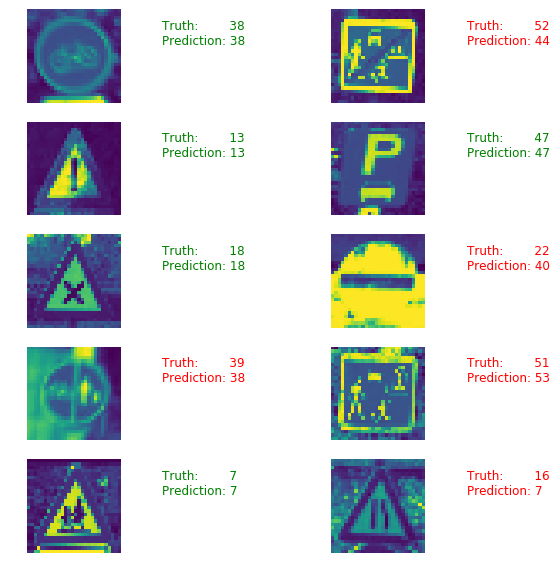

In [24]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])

plt.show()

In [25]:
test_images, test_labels = load_data(test_data_directory)

In [26]:
test_images28 = [transform.resize(image, (28, 28)) for image in test_images]

In [27]:
test_images28 = rgb2gray(np.array(test_images28))

In [28]:
predicted = sess.run([correct_pred], feed_dict={x: test_images28})[0]

In [29]:
match_count = sum([int(y==y_) for y, y_ in zip(test_labels, predicted)])

In [30]:
accuracy = match_count / len(test_labels)

In [31]:
print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.670


In [32]:
sess.close()